# Evaluate ICL Model on the Omniglot Classification Dataset

In [45]:
from jaxl.constants import *
from jaxl.datasets import get_dataset
from jaxl.datasets.wrappers import (
    ContextDataset,
    StandardSupervisedDataset,
    FixedLengthContextDataset,
    RepeatedContextDataset,
)
from jaxl.models import load_config, load_model, get_model, get_activation
from jaxl.plot_utils import set_size
from jaxl.utils import parse_dict, get_device

import _pickle as pickle
import copy
import jax
import jax.random as jrandom
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import torchvision.datasets as torch_datasets

from collections import OrderedDict
from functools import partial
from orbax.checkpoint import PyTreeCheckpointer, CheckpointManager
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader
from types import SimpleNamespace

In [46]:
# device = "cpu"
device = "gpu:0"
get_device(device)

In [47]:
doc_width_pt = 750.0

base_path = "/home/bryanpu1/projects/icl/jaxl/"
data_path = os.path.join(base_path, "data")
log_path = os.path.join(base_path, "jaxl/logs")
project_name = "icl-omniglot"
# ablation_name = "bursty_ablation"
ablation_name = "bursty_ablation-fixed_length"
# ablation_name = ""
run_name = (
    # "bursty_0.0-context_len_8-03-04-24_11_06_22-7a6e6aca-b77d-401d-842e-9bdddc5eeaa1"
    # "bursty_1.0-context_len_8-03-04-24_11_06_28-33b976d7-422f-4d66-ae9f-3bd86f1bd451"
    # "bursty_0.5-context_len_8-03-04-24_11_06_15-b2563eae-7e83-4b45-aa00-eb6d770c5fc5"

    # "bursty_0.0-context_len_8-batch_norm-03-05-24_07_56_37-1c4d12c3-4363-4cb6-bcda-6b25932cc9ea"
    # "bursty_0.5-context_len_8-batch_norm-03-05-24_07_55_58-a4d55433-45e2-406f-869a-ccd082c2b983"
    "bursty_1.0-context_len_8-batch_norm-03-05-24_07_57_05-f318fcb7-b332-4719-8917-028876194a02"

    # "bursty_0.0-context_len_8-batch_norm-no_aug-03-06-24_09_04_24-b772c27c-1592-4be2-a24e-b1b1c56e4761"
    # "bursty_0.5-context_len_8-batch_norm-no_aug-03-06-24_09_04_50-25fc1859-2f1c-4758-8d6a-a893d59425d7"
    # "bursty_1.0-context_len_8-batch_norm-no_aug-03-06-24_09_04_16-feec38cd-486e-4885-a108-961c93061a7b"
)

learner_path = os.path.join(
    log_path,
    project_name,
    ablation_name,
    run_name,
)

exp_name = "-".join(run_name.split("-")[:-8])

# Experiment Configuration

In [48]:
config_dict, config = load_config(learner_path)
fixed_length = config.learner_config.dataset_config.dataset_wrapper.type in ["FixedLengthContextDataset"]

In [49]:
config

namespace(logging_config=namespace(save_path='./logs/icl-omniglot/bursty_ablation-fixed_length',
                                   experiment_name='bursty_1.0-context_len_8-batch_norm',
                                   log_interval=50,
                                   checkpoint_interval=50000),
          model_config=namespace(architecture='icl_gpt',
                                 num_contexts=8,
                                 num_blocks=8,
                                 num_heads=8,
                                 embed_dim=64,
                                 positional_encoding=namespace(type='default',
                                                               kwargs=namespace(embed_dim=64,
                                                                                max_len=9)),
                                 input_tokenizer=namespace(type='resnet',
                                                           kwargs=namespace(blocks_per_group=[2,
               

# Load Dataset and Model

In [50]:
train_dataset = get_dataset(
    config.learner_config.dataset_config,
    config.learner_config.seeds.data_seed,
)

Files already downloaded and verified
Loading from /home/bryanpu1/projects/icl/data/omniglot_icl/omniglot_bursty-p_bursty_1.0-background_True-num_sequences_1000000-sequence_length_9-random_label_False-seed_42.pkl


In [51]:
params, model = load_model(
    train_dataset.input_dim, train_dataset.output_dim, learner_path, -1
)

Loading checkpoint: 500000


/home/bryanpu1/.conda/envs/icl_dev/lib/python3.9/site-packages/orbax/checkpoint/type_handlers.py:1475: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs.
  warnings.warn(


In [52]:
context_len = config.model_config.num_contexts
num_samples_per_task = train_dataset._dataset.sequence_length - 1
sequence_length = train_dataset._dataset.sequence_length
num_tasks = 100
num_workers = 4

print(num_samples_per_task, num_tasks, sequence_length, context_len)

8 100 9 8


In [53]:
train_loader = DataLoader(
    train_dataset,
    batch_size=num_samples_per_task,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
)

# Helper Functions

In [54]:
def get_preds_labels(data_loader, num_tasks, max_label=None):
    all_preds = []
    all_labels = []
    all_outputs = []

    for batch_i, samples in enumerate(data_loader):
        if batch_i >= num_tasks:
            break

        (context_inputs, context_outputs, queries, one_hot_labels) = samples

        outputs, _, _ = model.forward(
            params[CONST_MODEL_DICT][CONST_MODEL],
            queries.numpy(),
            {
                CONST_CONTEXT_INPUT: context_inputs.numpy(),
                CONST_CONTEXT_OUTPUT: context_outputs.numpy(),
            },
            eval=True,
        )
        # return train_outputs, train_updates, outputs, updates
        if max_label is None:
            preds = np.argmax(outputs, axis=-1)
        else:
            preds = np.argmax(outputs[..., :max_label], axis=-1)
        labels = np.argmax(one_hot_labels, axis=-1)
        all_preds.append(preds)
        all_labels.append(labels)
        all_outputs.append(outputs)

    all_outputs = np.concatenate(all_outputs)
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    return all_preds, all_labels, all_outputs


def print_performance(
    all_preds,
    all_labels,
    sequence_length,
    context_len,
    output_dim,
    fixed_length = False,
):
    conf_mat = confusion_matrix(all_labels, all_preds, labels=np.arange(output_dim))
    acc = np.trace(conf_mat) / np.sum(conf_mat) * 100
    print("Pretraining Accuracy: {}".format(acc))

    if not fixed_length:
        reshaped_preds = all_preds.reshape((-1, sequence_length - 1))
        reshaped_labels = all_labels.reshape((-1, sequence_length - 1))
        for curr_context_len in range(context_len):
            if curr_context_len < context_len - 1:
                curr_preds = reshaped_preds[:, curr_context_len]
                curr_labels = reshaped_labels[:, curr_context_len]
            else:
                curr_preds = reshaped_preds[:, curr_context_len:]
                curr_labels = reshaped_labels[:, curr_context_len:]

            curr_preds = curr_preds.reshape(-1)
            curr_labels = curr_labels.reshape(-1)

            curr_conf_mat = confusion_matrix(
                curr_labels, curr_preds, labels=np.arange(output_dim)
            )
            curr_acc = np.trace(curr_conf_mat) / np.sum(curr_conf_mat) * 100
            print(
                "Pretraining Accuracy with Context Length {} (Num Samples: {}): {}".format(
                    curr_context_len + 1, np.sum(curr_conf_mat), curr_acc
                )
            )

# Check Dataset

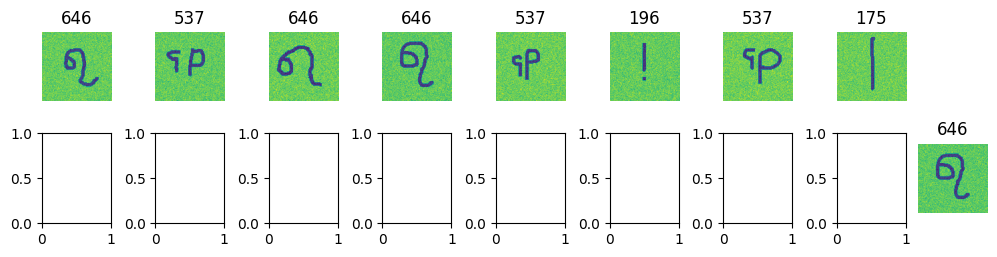

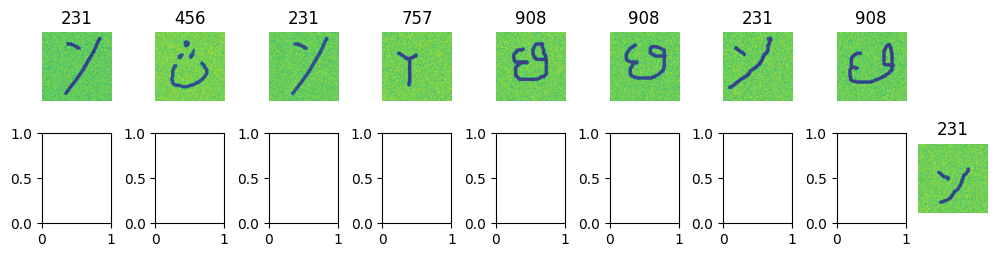

In [55]:
check = True
if check:
    for task_i in range(2):
        ci, co, q, l = train_dataset[
            task_i * num_samples_per_task + num_samples_per_task - 1
        ]

        nrows = 2
        ncols = 8
        fig, axes = plt.subplots(
            nrows,
            ncols + 1,
            figsize=set_size(doc_width_pt, 0.95, (nrows, ncols), False),
            layout="constrained",
        )

        for idx, (img, label) in enumerate(zip(ci, co)):
            axes[idx // ncols, idx % ncols].imshow(img)
            axes[idx // ncols, idx % ncols].set_title(np.argmax(label))
            axes[idx // ncols, idx % ncols].axis('off')
        axes[0, -1].axis('off')
        axes[1, -1].axis('off')
        axes[1, -1].imshow(q[0])
        axes[1, -1].set_title(np.argmax(l, axis=-1))
        plt.show()
        plt.close()

# Get Training Performance

In [56]:
train_preds, train_labels, train_outputs = get_preds_labels(train_loader, num_tasks)
pickle.dump(
    [train_preds, train_labels, train_outputs],
    open("train_prediction_result.pkl", "wb"),
)

/home/bryanpu1/.conda/envs/icl_dev/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/bryanpu1/.conda/envs/icl_dev/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [57]:
print_performance(
    train_preds,
    train_labels,
    sequence_length,
    context_len,
    train_dataset.output_dim[0],
    fixed_length=fixed_length,
)

Pretraining Accuracy: 99.5


# In-distribution Test Data

In [58]:
num_in_dist_test_tasks = 30
in_dist_test_data_seed = 1000

In [59]:
config.learner_config.dataset_config

namespace(dataset_name='omniglot',
          dataset_kwargs=namespace(save_path='/home/bryanpu1/projects/icl/data',
                                   task_name='multitask_omniglot_bursty',
                                   task_config=namespace(num_sequences=1000000,
                                                         sequence_length=9,
                                                         random_label=False,
                                                         p_bursty=1.0,
                                                         save_dir='/home/bryanpu1/projects/icl/data/omniglot_icl',
                                                         augmentation=True,
                                                         noise_scale=0.1)),
          dataset_wrapper=namespace(type='FixedLengthContextDataset',
                                    kwargs=namespace(context_len=8)),
          num_workers=4)

In [60]:
in_dist_test_config_dict = copy.deepcopy(
    config_dict["learner_config"]["dataset_config"]
)
in_dist_test_config_dict["dataset_kwargs"]["num_sequences"] = num_in_dist_test_tasks
in_dist_test_config_dict["dataset_kwargs"]["task_config"]["p_bursty"] = 0.0
# in_dist_test_config_dict["dataset_kwargs"]["task_config"]["augmentation"] = True
# in_dist_test_config_dict["dataset_kwargs"]["task_config"]["noise_scale"] = 0.1
in_dist_test_config = parse_dict(in_dist_test_config_dict)

In [61]:
in_dist_test_dataset = get_dataset(
    in_dist_test_config,
    in_dist_test_data_seed,
)

Files already downloaded and verified
Loading from /home/bryanpu1/projects/icl/data/omniglot_icl/omniglot_bursty-p_bursty_0.0-background_True-num_sequences_1000000-sequence_length_9-random_label_False-seed_1000.pkl


## Check Dataset

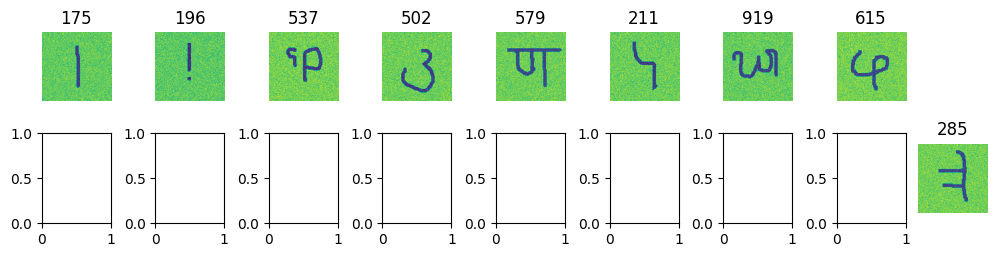

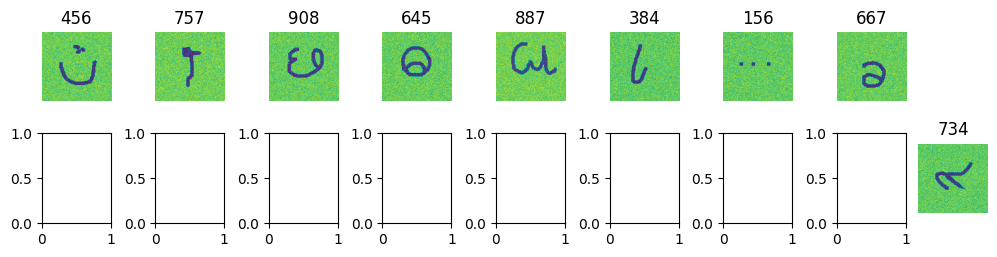

In [62]:
check = True
if check:
    for task_i in range(2):
        ci, co, q, l = in_dist_test_dataset[
            task_i * num_samples_per_task + num_samples_per_task - 1
        ]

        nrows = 2
        ncols = 8
        fig, axes = plt.subplots(
            nrows,
            ncols + 1,
            figsize=set_size(doc_width_pt, 0.95, (nrows, ncols), False),
            layout="constrained",
        )

        for idx, (img, label) in enumerate(zip(ci, co)):
            axes[idx // ncols, idx % ncols].imshow(img)
            axes[idx // ncols, idx % ncols].set_title(np.argmax(label))
            axes[idx // ncols, idx % ncols].axis('off')
        axes[0, -1].axis('off')
        axes[1, -1].axis('off')
        axes[1, -1].imshow(q[0])
        axes[1, -1].set_title(np.argmax(l, axis=-1))
        plt.show()
        plt.close()

In [63]:
in_dist_test_loader = DataLoader(
    in_dist_test_dataset,
    batch_size=num_samples_per_task,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
)

In [64]:
in_dist_test_preds, in_dist_test_labels, in_dist_test_outputs = get_preds_labels(
    in_dist_test_loader, num_in_dist_test_tasks
)
pickle.dump(
    [in_dist_test_preds, in_dist_test_labels, in_dist_test_outputs],
    open("in_dist_test_prediction_result.pkl", "wb"),
)

/home/bryanpu1/.conda/envs/icl_dev/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/bryanpu1/.conda/envs/icl_dev/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [65]:
print_performance(
    in_dist_test_preds,
    in_dist_test_labels,
    sequence_length,
    context_len,
    in_dist_test_dataset.output_dim[0],
    fixed_length=fixed_length,
)

Pretraining Accuracy: 28.749999999999996


# Relabel Train Data

In [66]:
num_remap_train_tasks = 30
remap_train_data_seed = 1000

In [67]:
remap_train_config_dict = copy.deepcopy(config_dict["learner_config"]["dataset_config"])
remap_train_config_dict["dataset_kwargs"]["train"] = True
remap_train_config_dict["dataset_kwargs"]["remap"] = True
remap_train_config_dict["dataset_kwargs"]["task_name"] = CONST_MULTITASK_OMNIGLOT_N_SHOT_K_WAY
remap_train_config_dict["dataset_kwargs"]["task_config"]["p_bursty"] = 1.0
remap_train_config_dict["dataset_kwargs"]["task_config"]["k_way"] = 2
remap_train_config_dict["dataset_kwargs"]["num_sequences"] = num_remap_train_tasks
remap_train_config = parse_dict(remap_train_config_dict)

In [68]:
remap_train_dataset = get_dataset(
    remap_train_config,
    remap_train_data_seed,
)

Files already downloaded and verified
Loading from /home/bryanpu1/projects/icl/data/omniglot_icl/omniglot_bursty-p_bursty_1.0-background_True-num_sequences_1000000-sequence_length_9-random_label_False-seed_1000.pkl


## Check Dataset

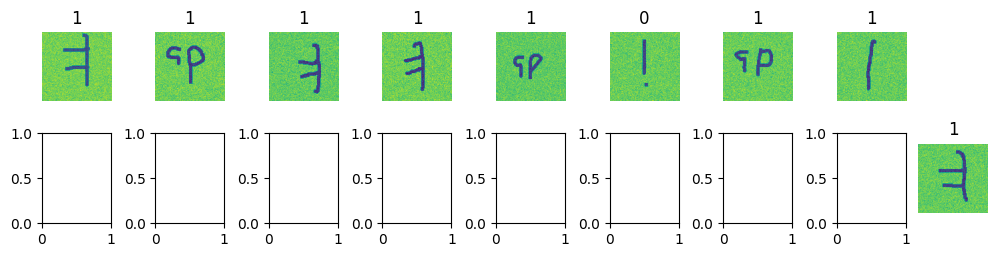

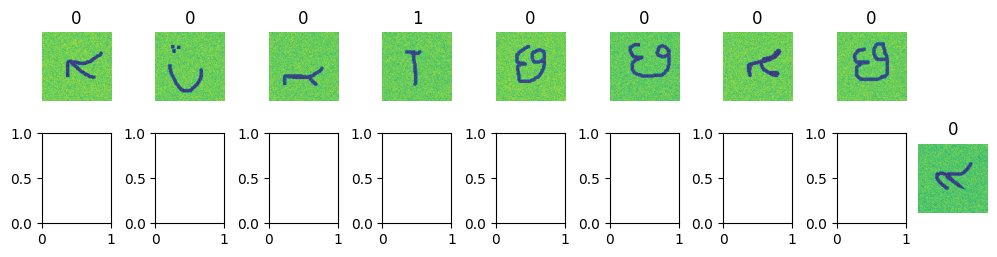

In [69]:
check = True
if check:
    for task_i in range(2):
        ci, co, q, l = remap_train_dataset[
            task_i * num_samples_per_task + num_samples_per_task - 1
        ]

        nrows = 2
        ncols = 8
        fig, axes = plt.subplots(
            nrows,
            ncols + 1,
            figsize=set_size(doc_width_pt, 0.95, (nrows, ncols), False),
            layout="constrained",
        )

        for idx, (img, label) in enumerate(zip(ci, co)):
            axes[idx // ncols, idx % ncols].imshow(img)
            axes[idx // ncols, idx % ncols].set_title(np.argmax(label))
            axes[idx // ncols, idx % ncols].axis('off')
        axes[0, -1].axis('off')
        axes[1, -1].axis('off')
        axes[1, -1].imshow(q[0])
        axes[1, -1].set_title(np.argmax(l, axis=-1))
        plt.show()
        plt.close()

In [70]:
remap_train_loader = DataLoader(
    remap_train_dataset,
    batch_size=num_samples_per_task,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
)

In [71]:
remap_train_preds, remap_train_labels, remap_train_outputs = get_preds_labels(
    remap_train_loader, num_remap_train_tasks, max_label=2,
)
pickle.dump(
    [remap_train_preds, remap_train_labels, remap_train_outputs],
    open("remap_train_prediction_result.pkl", "wb"),
)

/home/bryanpu1/.conda/envs/icl_dev/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/bryanpu1/.conda/envs/icl_dev/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [72]:
print_performance(
    remap_train_preds,
    remap_train_labels,
    sequence_length,
    context_len,
    remap_train_dataset.output_dim[0],
    fixed_length=fixed_length,
)

Pretraining Accuracy: 70.41666666666667


# Out-of-class Test Data
This checks out-of-class generalization (i.e. heldout classes)

In [73]:
num_ooc_test_tasks = 30
ooc_test_data_seed = 1000

In [74]:
ooc_test_config_dict = copy.deepcopy(config_dict["learner_config"]["dataset_config"])
ooc_test_config_dict["dataset_kwargs"]["train"] = False
ooc_test_config_dict["dataset_kwargs"]["remap"] = False
ooc_test_config_dict["dataset_kwargs"]["task_config"]["p_bursty"] = 1.0
ooc_test_config_dict["dataset_kwargs"]["num_sequences"] = num_ooc_test_tasks
ooc_test_config = parse_dict(ooc_test_config_dict)

In [75]:
ooc_test_dataset = get_dataset(
    ooc_test_config,
    ooc_test_data_seed,
)

Files already downloaded and verified
Loading from /home/bryanpu1/projects/icl/data/omniglot_icl/omniglot_bursty-p_bursty_1.0-background_False-num_sequences_1000000-sequence_length_9-random_label_False-seed_1000.pkl


## Check Dataset

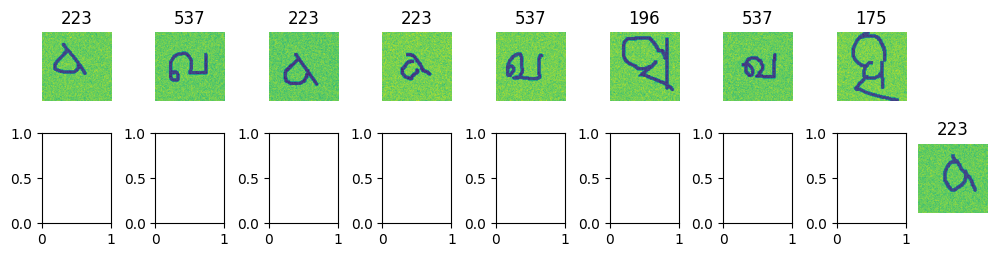

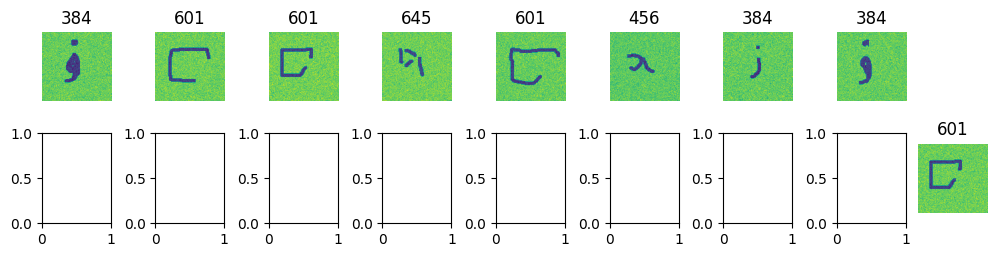

In [76]:
check = True
if check:
    for task_i in range(2):
        ci, co, q, l = ooc_test_dataset[
            task_i * num_samples_per_task + num_samples_per_task - 1
        ]

        nrows = 2
        ncols = 8
        fig, axes = plt.subplots(
            nrows,
            ncols + 1,
            figsize=set_size(doc_width_pt, 0.95, (nrows, ncols), False),
            layout="constrained",
        )

        for idx, (img, label) in enumerate(zip(ci, co)):
            axes[idx // ncols, idx % ncols].imshow(img)
            axes[idx // ncols, idx % ncols].set_title(np.argmax(label))
            axes[idx // ncols, idx % ncols].axis('off')
        axes[0, -1].axis('off')
        axes[1, -1].axis('off')
        axes[1, -1].imshow(q[0])
        axes[1, -1].set_title(np.argmax(l, axis=-1))
        plt.show()
        plt.close()

In [77]:
ooc_test_loader = DataLoader(
    ooc_test_dataset,
    batch_size=num_samples_per_task,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
)

In [78]:
ooc_test_preds, ooc_test_labels, ooc_test_outputs = get_preds_labels(
    ooc_test_loader, num_ooc_test_tasks, max_label=ooc_test_dataset._data["max_num_classes"]
)
pickle.dump(
    [ooc_test_preds, ooc_test_labels, ooc_test_outputs],
    open("ooc_test_prediction_result.pkl", "wb"),
)

/home/bryanpu1/.conda/envs/icl_dev/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/bryanpu1/.conda/envs/icl_dev/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [79]:
print_performance(
    ooc_test_preds,
    ooc_test_labels,
    sequence_length,
    context_len,
    ooc_test_dataset.output_dim[0],
    fixed_length=fixed_length,
)

Pretraining Accuracy: 1.25


# Relabel Test Data
Maps the labels to a constrained subset

In [80]:
num_remap_test_tasks = 30
remap_test_data_seed = 1000

In [81]:
remap_test_config_dict = copy.deepcopy(config_dict["learner_config"]["dataset_config"])
remap_test_config_dict["dataset_kwargs"]["train"] = False
remap_test_config_dict["dataset_kwargs"]["remap"] = True
remap_test_config_dict["dataset_kwargs"]["task_name"] = CONST_MULTITASK_OMNIGLOT_N_SHOT_K_WAY
remap_test_config_dict["dataset_kwargs"]["task_config"]["p_bursty"] = 1.0
remap_test_config_dict["dataset_kwargs"]["task_config"]["k_way"] = 2
remap_test_config_dict["dataset_kwargs"]["num_sequences"] = num_remap_test_tasks
remap_test_config = parse_dict(remap_test_config_dict)

In [82]:
remap_test_dataset = get_dataset(
    remap_test_config,
    remap_test_data_seed,
)

Files already downloaded and verified
Loading from /home/bryanpu1/projects/icl/data/omniglot_icl/omniglot_bursty-p_bursty_1.0-background_False-num_sequences_1000000-sequence_length_9-random_label_False-seed_1000.pkl


In [83]:
remap_test_loader = DataLoader(
    remap_test_dataset,
    batch_size=num_samples_per_task,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
)

In [84]:
remap_test_preds, remap_test_labels, remap_test_outputs = get_preds_labels(
    remap_test_loader, num_remap_test_tasks, max_label=2
)
pickle.dump(
    [remap_test_preds, remap_test_labels, remap_test_outputs],
    open("remap_test_prediction_result.pkl", "wb"),
)

/home/bryanpu1/.conda/envs/icl_dev/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/bryanpu1/.conda/envs/icl_dev/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [85]:
print_performance(
    remap_test_preds,
    remap_test_labels,
    sequence_length,
    context_len,
    remap_test_dataset.output_dim[0],
    fixed_length=fixed_length,
)

Pretraining Accuracy: 73.75


In [86]:
remap_test_preds, remap_test_labels, remap_test_outputs = get_preds_labels(
    remap_test_loader, num_remap_test_tasks
)
pickle.dump(
    [remap_test_preds, remap_test_labels, remap_test_outputs],
    open("remap_test_prediction_result-unconstrained.pkl", "wb"),
)

/home/bryanpu1/.conda/envs/icl_dev/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/bryanpu1/.conda/envs/icl_dev/lib/python3.9/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [87]:

print_performance(
    remap_test_preds,
    remap_test_labels,
    sequence_length,
    context_len,
    remap_test_dataset.output_dim[0],
    fixed_length=fixed_length,
)

Pretraining Accuracy: 1.6666666666666667
